# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *E*

**Names:**

* *Ali Essonni*
* *Enrico Benedettini*
* *Youssef Amine*
* *Mak Fazlic*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

In [2]:
import epidemics_helper
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Simulating an epidemic with the following parameters
# start node = 23654
# beta = 10
# gamma = 0.1

# First importing the json data and creating a graph from it
G = nx.Graph()
data = {}
with open('../data/nyc_augmented_network.json') as json_file:
    data = json.load(json_file)

edges = data['links']
edges = [(edge['source'], edge['target']) for edge in edges]
G.add_edges_from(edges)

coord = data['nodes']
coord = [c['coordinates'] for c in coord]

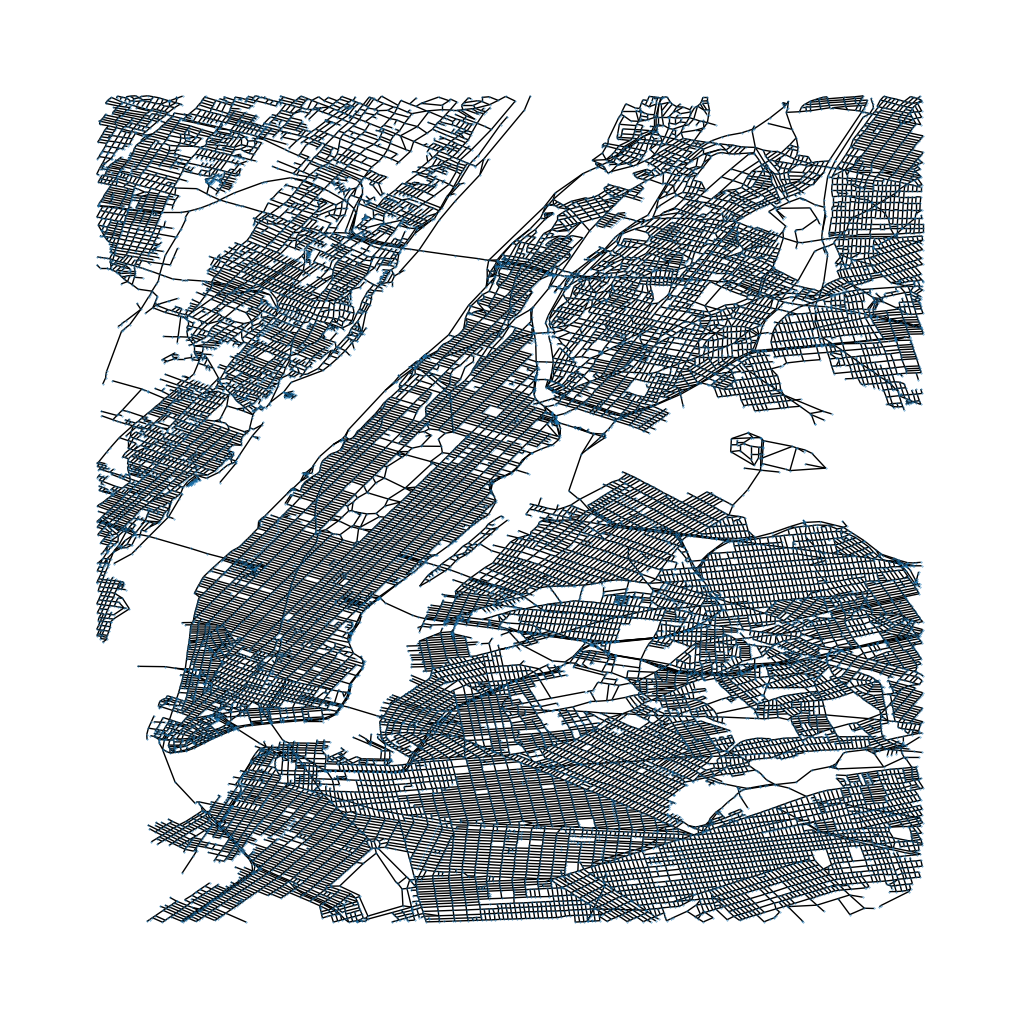

In [4]:
# Now we draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos=coord, with_labels=False, node_size=0.1)
plt.show()

#### 1 - Launching the epidemic at node 23654 with infection rate: 10.0 and recovery rate: 0.1

In [5]:
# Simulating the epidemic propagation through the graph
sir = epidemics_helper.SimulationSIR(G, beta=10.0, gamma=0.1)
sir.launch_epidemic(source=23654, max_time=100)

Epidemic stopped after 118.80 days | 118.80 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered


#### 2 - Plotting the variation of the number of suceptible, infected and recovered nodes over time

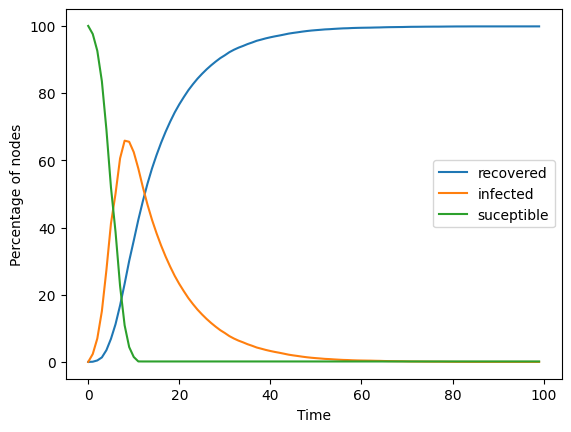

In [6]:
# infection_times is a numpy array of the time of infection of each node (the node id is the index)
# recover_times is a numpy array of the time of recovery of each node (the node id is the index)
infection_times = sir.inf_time
recover_times = sir.rec_time

# count the number of recovered nodes at each time step
recovered = np.zeros(100)
infected = np.zeros(100)
suceptible = np.zeros(100)

for i in range(100):
    recovered[i] = np.count_nonzero(recover_times <= i)
    infected[i] = np.count_nonzero(infection_times <= i) - recovered[i]
    suceptible[i] = len(G.nodes()) - infected[i] - recovered[i]

recovered = (recovered / len(G.nodes())) * 100
infected = (infected / len(G.nodes())) * 100
suceptible = (suceptible / len(G.nodes())) * 100

# plotting the percentage of suceptible, infected and recovered nodes at each time step
plt.plot(recovered, label="recovered")
plt.plot(infected, label="infected")
plt.plot(suceptible, label="suceptible")
plt.xlabel("Time")
plt.ylabel("Percentage of nodes")
plt.legend()
plt.show()

#### 3 - How long until 60% of the population is infected (at the same time)? recovered?

In [7]:
# Time at which 60% of the population is infected at the same time
x = np.where(infected >= 60)[0][0]
print("Time at which 60% of the population is infected at the same time: day", x)

# Time at which 60% of the population is either infected or recovered
y = np.where((infected + recovered) >= 60)[0][0]
print("Time at which 60% of the population is either infected or recovered: day", y)

# Time at which 60% of the population is recovered
z = np.where(recovered >= 60)[0][0]
print("Time at which 60% of the population is recovered: day", z)

Time at which 60% of the population is infected at the same time: day 7
Time at which 60% of the population is either infected or recovered: day 6
Time at which 60% of the population is recovered: day 15


#### 4 - Visualizing the epidemic on the network at different timestamps

In [8]:
def nodes_color(G, sir, day):
    colors = []
    for node in G.nodes:
        status = sir.get_node_status(node, day)
        colors.append("green" if status == 0 else "red" if status == 1 else "blue")
    return colors

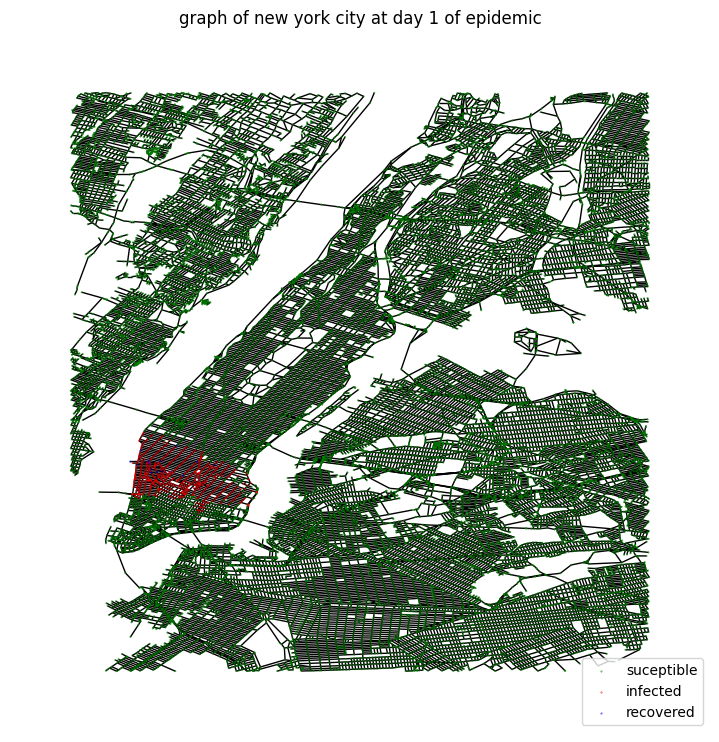

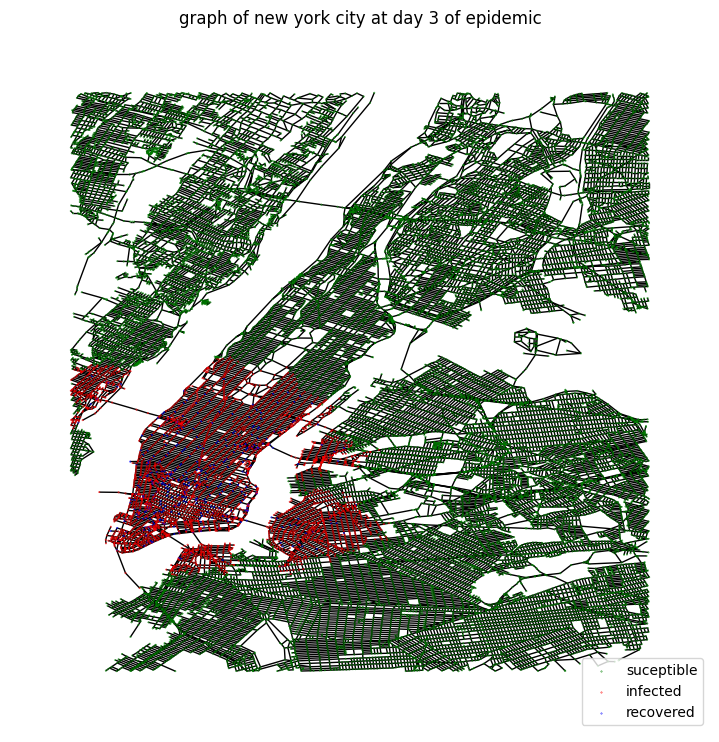

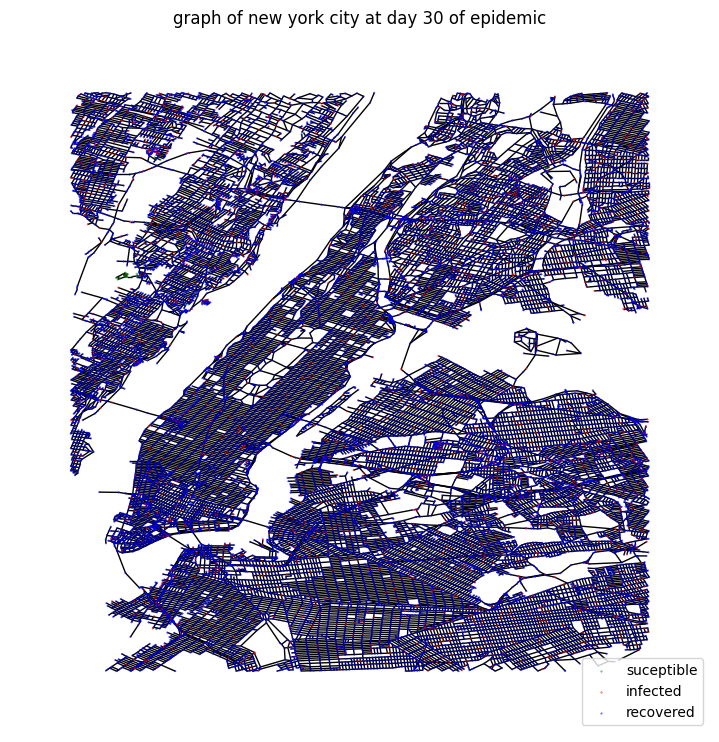

In [9]:
colors_1 = nodes_color(G, sir, 1)
colors_3 = nodes_color(G, sir, 3)
colors_30 = nodes_color(G, sir, 30)

# draw the graph G with the color map colors_30 with the title "graph of new york city at day 30 of epidemic"
plt.figure(figsize=(7, 7))
nx.draw(G, pos=coord, with_labels=False, node_size=0.1, node_color=colors_1)
# add legend to the graph, green = suceptible, red = infected, blue = recovered
plt.legend(handles=[plt.scatter([], [], c="green", s=0.1), plt.scatter([], [], c="red", s=0.1), plt.scatter([], [], c="blue", s=0.1)], labels=["suceptible", "infected", "recovered"])
plt.title("graph of new york city at day 1 of epidemic")
plt.figure(figsize=(7, 7))
nx.draw(G, pos=coord, with_labels=False, node_size=0.1, node_color=colors_3)
plt.legend(handles=[plt.scatter([], [], c="green", s=0.1), plt.scatter([], [], c="red", s=0.1), plt.scatter([], [], c="blue", s=0.1)], labels=["suceptible", "infected", "recovered"])
plt.title("graph of new york city at day 3 of epidemic")
plt.figure(figsize=(7, 7))
nx.draw(G, pos=coord, with_labels=False, node_size=0.1, node_color=colors_30)
plt.legend(handles=[plt.scatter([], [], c="green", s=0.1), plt.scatter([], [], c="red", s=0.1), plt.scatter([], [], c="blue", s=0.1)], labels=["suceptible", "infected", "recovered"])
plt.title("graph of new york city at day 30 of epidemic")
plt.show()


---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

##### We will first create a function to remove n edges from the graph uniformly at random, and a helper function to compute the number of suceptible, infected and recovered nodes at a given time step.

In [10]:
# removing uniformly at random n edges from the graph
def rand_removed_edges(G, n):
    """
    :param G: a networkx graph
    :param n: the number of edges to remove
    :return: a new graph with n edges removed
    """
    y  = np.random.randint(0, high=len(G.edges), size=n)
    z = np.array(G.edges)[y]
    H = G.copy()
    H.remove_edges_from(z)
    return H

In [11]:
# Hepler method to compute the statistics of the simulation at day 30
def simulation_statistics(G, sim, n, strategy):
    """
    :param G: the graph
    :param sim: the simulation
    :param n: the number of edges removed from the graph
    :return: prints the number of infected, recovered and suceptible nodes at day 30
    """

    nodes = list(G.nodes)
    # mapping each node in nodes to its status at day 30
    nodes = list(map(lambda x: sim.get_node_status(x, 30), nodes))
    suceptible30 = round(nodes.count(0)*100/len(nodes), 2)
    infected30 = round(nodes.count(1)*100/len(nodes), 2)
    recovered30 = round(nodes.count(2)*100/len(nodes), 2)

    print("Statistics for ", n , " edges removed using strategy: ", str(strategy))
    print("Suceptible nodes at day 30:", suceptible30, "%")
    print("Infected nodes at day 30:", infected30, "%")
    print("Recovered nodes at day 30:", recovered30, "%")

In [13]:
# Sampling 1000 edges uniformly at random and removing them from the graph
H1 = rand_removed_edges(G, 1000)
H2 = rand_removed_edges(G, 10000)

# instantiating an sir model
sir1 = epidemics_helper.SimulationSIR(H1, beta=10.0, gamma=0.1, verbose=False)
source1 = np.random.randint(0, high=len(G.nodes))
sir1.launch_epidemic(source=source1, max_time=100)

sir2 = epidemics_helper.SimulationSIR(H2, beta=10.0, gamma=0.1, verbose=False)
source2 = np.random.randint(0, high=len(G.nodes))
sir2.launch_epidemic(source=source2, max_time=100)

# Printing the statistics for the graph with 1000 removed edges
simulation_statistics(H1, sir1, 1000, "random")
print("-----------------------------")
# Printing the statistics for the graph with 10000 removed edges
simulation_statistics(H2, sir2, 10000, "random")



Statistics for  1000  edges removed using strategy:  random
Suceptible nodes at day 30: 0.39 %
Infected nodes at day 30: 8.73 %
Recovered nodes at day 30: 90.88 %
-----------------------------
Statistics for  10000  edges removed using strategy:  random
Suceptible nodes at day 30: 10.86 %
Infected nodes at day 30: 22.79 %
Recovered nodes at day 30: 66.35 %


#### We can see that removing edges at random is a very inefficient and suboptimal strategy, as it does not take into account the structure of the network, leading to very poor results.
#### In fact our network is composed of some main clusters of nodes that are strongly connected, these clusters however are connected between them by a few weak edges, it would be more interesting to target nodes that connect those big clusters and see what results we get.

#### Exercise 2.11: Strategy 2

#### Before we start coding, let us first explain the strategy, which is the following:
#### The idea is to remove the edges that are more suceptible to propagate the epidemic, and those are the weak edges of the graph (the edges for wich the nodes don't form a triangle). But since we suspect to have a lot more of these edges than the 2500 budget, we will sort them using the mean degree of the two nodes they connect, and remove the edges ranked the lowest.
#### This will guarantee taht from the weak edges of the graph, we only really target the onces that are the least acessible from the rest of the graph, and thus the most suceptible to propagate the epidemic.

In [22]:
def strategical_graph(G, n):
    """
    :param G: a networkx graph
    :param n: the number of edges to remove
    :return: a new graph with n edges removed following the strategy described above
    """
    # create a copy of the graph
    G_copy = G.copy()
    
    # find local bridges in H4 using networkx method
    local_bridges = list(nx.local_bridges(G_copy))
    local_bridges.sort(key=lambda x: (G.degree(x[0])+G.degree(x[1])/2))

    bridges_to_remove = local_bridges[:n]
    G_copy.remove_edges_from(bridges_to_remove)
    return G_copy

In [23]:
# new Graph with 2500 edges removed using the strategical method
H3 = strategical_graph(G, 2500)

In [24]:
# starting new simulation
sir4 = epidemics_helper.SimulationSIR(H3, beta=10.0, gamma=0.1, verbose=False)

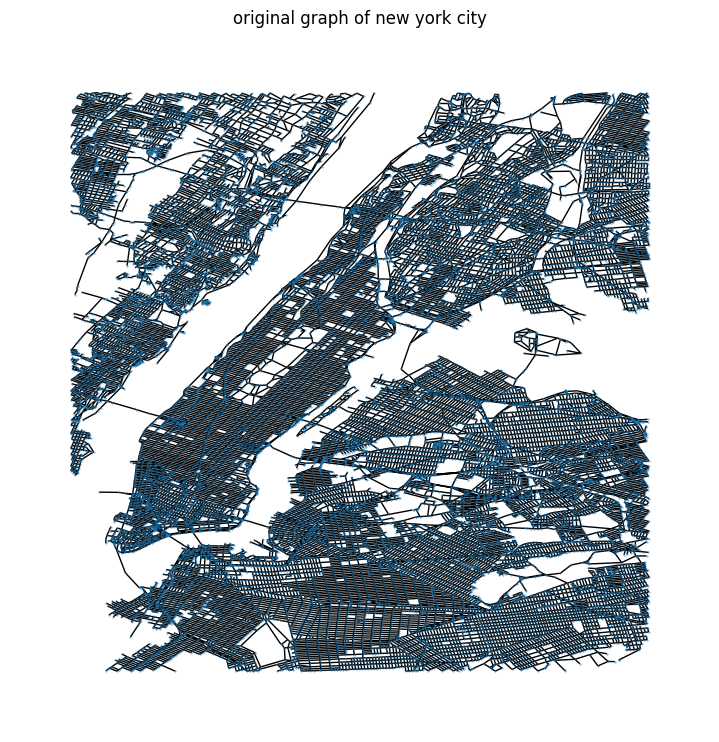

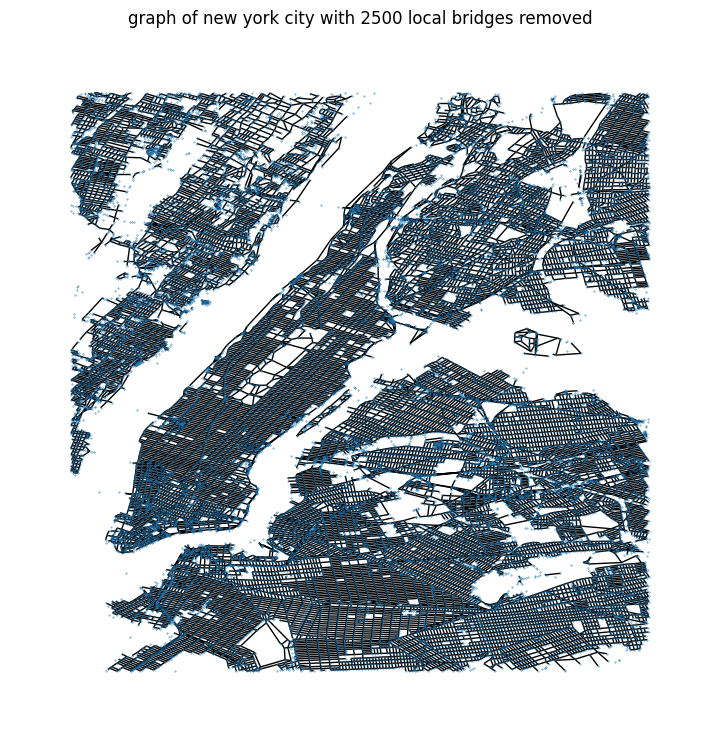

In [25]:
plt.figure(figsize=(7, 7))
nx.draw(G, pos=coord, with_labels=False, node_size=0.1)
plt.title("original graph of new york city")

plt.figure(figsize=(7, 7))
nx.draw(H3, pos=coord, with_labels=False, node_size=0.1)
plt.title("graph of new york city with 2500 local bridges removed")
plt.show()

#### We can clearly see in the 2nd figure that the clusters have been disconnected by removing strategic bridges that connected them.

In [26]:
# helper method to compute the statistics of the simulation at day 30
def simulation_statistics2(G, sim, n):
    """
    :param G: the graph
    :param sim: the simulation
    :param n: the number of edges removed from the graph
    :return: prints the number of infected, recovered and suceptible nodes at day 30
    """
    suceptibleG = np.zeros(100)
    for i in range(100):
        sim.launch_epidemic(source=np.random.randint(0, high=len(G.nodes)-1), max_time=100)
        state_at_30 = []
        for j in list(G.nodes()):
            state_at_30.append(sim.get_node_status(j, 30))
        suceptibleG[i] = (state_at_30.count(0)*100)/len(G.nodes())

    # print the number of infected, recovered and suceptible nodes at day 30
    print("Statistics for the graph with ", n, " edges removed based on local bridges and node degree")
    print("Average number of suceptible nodes at day 30: ", np.mean(suceptibleG))

In [27]:
# Now we run the simulation for 100 times starting at random nodes
simulation_statistics2(H3, sir4, 2500)

Statistics for the graph with  2500  edges removed based on local bridges and node degree
Average number of suceptible nodes at day 30:  72.89751142328463


#### As we can see, our strategy is very effective, it bumps up the number of suceptible nodes to  70%, which is a lot higher than the random strategy.